In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from timm import create_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

In [2]:
# Directories for training, validation, and testing
train_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/1.train"
val_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/2.val"
test_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/3.test"

# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 32

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load DeiT Model
model = create_model("deit_base_patch16_224", pretrained=True, num_classes=len(train_dataset.classes))
model = model.cuda()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the Model
epochs = 10
training_time = 0
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    
    epoch_time = time.time() - start_time
    training_time += epoch_time
    print(f"Epoch {epoch+1}/{epochs} - Train Accuracy: {train_accuracy:.2f}% - Val Accuracy: {val_accuracy:.2f}% - Time: {epoch_time:.2f}s")

# Evaluate Model
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

class_labels = train_dataset.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/10 - Train Accuracy: 57.52% - Val Accuracy: 70.59% - Time: 80.65s
Epoch 2/10 - Train Accuracy: 81.82% - Val Accuracy: 74.26% - Time: 63.42s
Epoch 3/10 - Train Accuracy: 89.03% - Val Accuracy: 80.15% - Time: 63.38s
Epoch 4/10 - Train Accuracy: 94.36% - Val Accuracy: 81.62% - Time: 64.35s
Epoch 5/10 - Train Accuracy: 95.61% - Val Accuracy: 82.35% - Time: 64.64s
Epoch 6/10 - Train Accuracy: 96.08% - Val Accuracy: 79.41% - Time: 65.11s
Epoch 7/10 - Train Accuracy: 96.71% - Val Accuracy: 81.62% - Time: 65.58s
Epoch 8/10 - Train Accuracy: 96.39% - Val Accuracy: 77.94% - Time: 66.00s
Epoch 9/10 - Train Accuracy: 95.92% - Val Accuracy: 82.35% - Time: 65.94s
Epoch 10/10 - Train Accuracy: 96.24% - Val Accuracy: 82.35% - Time: 65.09s
Classification Report:
                         precision    recall  f1-score   support

         1. No DR signs       0.85      0.79      0.81        28
2. Mild (or early) NPDR       1.00      1.00      1.00        24
       3. Moderate NPDR       0.73      

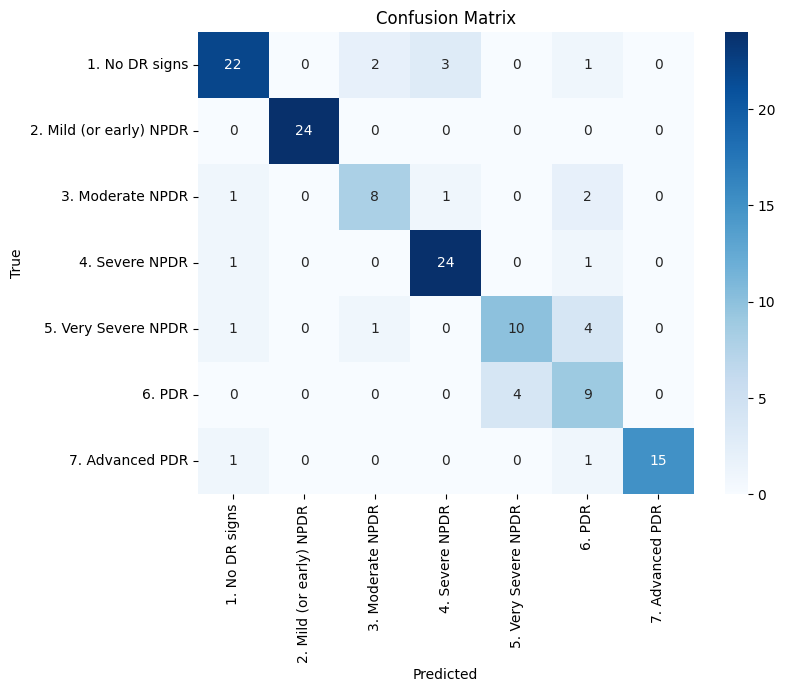

Training Time: 664.16 seconds
Accuracy: 0.8235
Precision: 0.8064
Recall (Sensitivity): 0.7964
F1-Score: 0.7977
Specificity: 0.9650


In [3]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")